In [52]:
#Portfolio Optimization

In [4]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import datetime
import scipy.optimize as optimization

In [33]:
#stocks - Wells Fargo, Apple, ..
stocks = ['WFC','WMT','TSLA','GE','AMZN','AAPL']

In [53]:
# taking last 10 years records
now = datetime.datetime.now()
lastyear = now - datetime.timedelta(days = 4000)

In [35]:
#downloading the data from Yahoo! Finance
def download_data(stocks):
	data = web.DataReader(stocks,data_source='yahoo',start=lastyear,end=now)['Adj Close']	
	return data
data = download_data(stocks)
data.head()

Symbols,AAPL,AMZN,GE,TSLA,WFC,WMT
Date,,,,,,
2007-10-25,23.141403,88.209999,26.504784,NaN,25.339615,33.635391
2007-10-26,23.384495,90.000000,26.649973,NaN,25.894228,34.217949
2007-10-29,23.433870,90.099998,26.768780,NaN,25.579443,34.501553
2007-10-30,23.675686,88.239998,26.715975,NaN,25.482012,34.777531
2007-10-31,24.049175,89.150002,27.164753,NaN,25.489510,34.654861


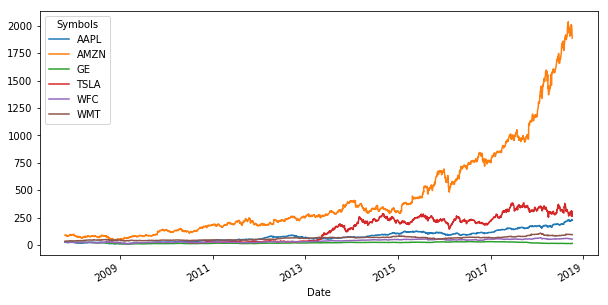

In [36]:
def show_data(data):
	data.plot(figsize=(10,5))
	plt.show()
show_data(data)

In [37]:
#we usually use natural logarithm for normalization purposes
def calculate_returns(data):
	returns = np.log(data/data.shift(1))
	return returns;
returns = calculate_returns(data)

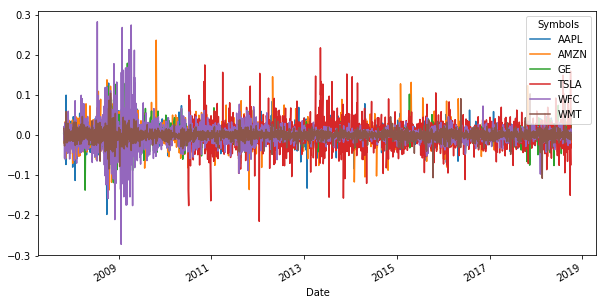

In [38]:
def plot_daily_returns(returns):
	returns.plot(figsize=(10,5))
	plt.show()
plot_daily_returns(returns)

In [39]:
#print out mean and covariance of stocks within [start_date, end_date]. There are 252 trading days within a year
def show_statistics(returns):
	print(returns.mean()*252)
	print(returns.cov()*252)
show_statistics(returns)

Symbols
AAPL    0.207682
AMZN    0.280202
GE     -0.063880
TSLA    0.289709
WFC     0.067801
WMT     0.093297
dtype: float64
Symbols      AAPL      AMZN        GE      TSLA       WFC       WMT
Symbols                                                            
AAPL     0.096230  0.053507  0.041950  0.028378  0.053203  0.018014
AMZN     0.053507  0.140360  0.045666  0.043901  0.062563  0.020909
GE       0.041950  0.045666  0.099845  0.025509  0.087029  0.021542
TSLA     0.028378  0.043901  0.025509  0.262054  0.027197  0.011108
WFC      0.053203  0.062563  0.087029  0.027197  0.208371  0.027543
WMT      0.018014  0.020909  0.021542  0.011108  0.027543  0.039630


In [40]:
#weights defines what stocks to include (with what portion) in the portfolio
def initialize_weights():
	weights = np.random.random(len(stocks))
	weights /= np.sum(weights)
	return weights;
weights=initialize_weights()

In [41]:
#expected portfolio return
def calculate_portfolio_return(returns, weights):
	portfolio_return = np.sum(returns.mean()*weights)*252
	print("Expected portfolio return:", portfolio_return)
calculate_portfolio_return(returns,weights)

Expected portfolio return: 0.1523729273641388


In [42]:
#expected portfolio variance
def calculate_portfolio_variance(returns, weights):
	portfolio_variance = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252,weights)))
	print("Expected variance:", portfolio_variance)
calculate_portfolio_variance(returns,weights)

Expected variance: 0.2346749527205495


In [43]:
def generate_portfolios(weights, returns):
	preturns = []
	pvariances = []
	#Monte-Carlo simulation: we generate several random weights -> so random portfolios !!!
	for i in range(10000):
		weights = np.random.random(len(stocks))
		weights/=np.sum(weights)
		preturns.append(np.sum(returns.mean()*weights)*252)
		pvariances.append(np.sqrt(np.dot(weights.T,np.dot(returns.cov()*252,weights))))	
	preturns = np.array(preturns)
	pvariances = np.array(pvariances)
	return preturns,pvariances
preturns,pvariances=generate_portfolios(weights, returns)

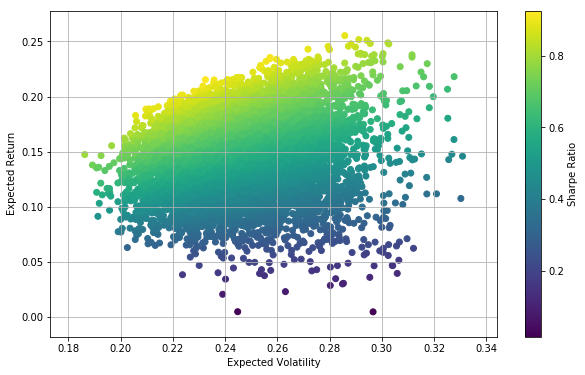

In [44]:
def plot_portfolios(returns, variances):
	plt.figure(figsize=(10,6))
	plt.scatter(variances,returns,c=returns/variances,marker='o')
	plt.grid(True)
	plt.xlabel('Expected Volatility')
	plt.ylabel('Expected Return')
	plt.colorbar(label='Sharpe Ratio')
	plt.show()
plot_portfolios(preturns,pvariances)

In [45]:
# OK this is the result of the simulation ... we have to find the optimal portfolio with 
# some optimization technique !!! scipy can optimize functions (minimum/maximum finding)
def statistics(weights, returns):
	portfolio_return=np.sum(returns.mean()*weights)*252
	portfolio_volatility=np.sqrt(np.dot(weights.T,np.dot(returns.cov()*252,weights)))
	return np.array([portfolio_return,portfolio_volatility,portfolio_return/portfolio_volatility])

In [46]:
# [2] means that we want to maximize according to the Sharpe-ration
# note: maximizing f(x) function is the same as minimizing -f(x) !!!
def	min_func_sharpe(weights,returns):
	return	-statistics(weights,returns)[2]

In [49]:
# what are the constraints? The sum of weights = 1 !!!  f(x)=0 this is the function to minimize
def optimize_portfolio(weights,returns):
	constraints = ({'type':'eq','fun': lambda x: np.sum(x)-1}) #the sum of weights is 1
	bounds = tuple((0,1) for x in range(len(stocks))) #the weights can be 1 at most: 1 when 100% of money is invested into a single stock
	optimum=optimization.minimize(fun=min_func_sharpe,x0=weights,args=returns,method='SLSQP',bounds=bounds,constraints=constraints) 
	return optimum
optimum=optimize_portfolio(weights,returns)

In [50]:
# optimal portfolio according to weights: 0 means no shares of that given company 
def print_optimal_portfolio(optimum, returns):
	print("Optimal weights:", optimum['x'].round(3))
	print("Expected return, volatility and Sharpe ratio:", statistics(optimum['x'].round(3),returns))
print_optimal_portfolio(optimum, returns)

Optimal weights: [0.267 0.296 0.    0.184 0.    0.252]
Expected return, volatility and Sharpe ratio: [0.2152081  0.23053859 0.93350139]


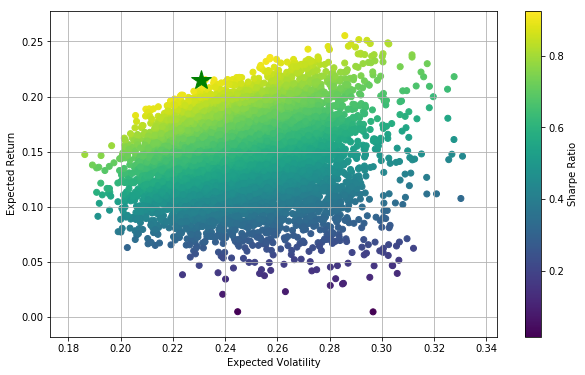

In [51]:
def show_optimal_portfolio(optimum, returns, preturns, pvariances):
	plt.figure(figsize=(10,6))
	plt.scatter(pvariances,preturns,c=preturns/pvariances,marker='o')
	plt.grid(True)
	plt.xlabel('Expected Volatility')
	plt.ylabel('Expected Return')
	plt.colorbar(label='Sharpe Ratio')
	plt.plot(statistics(optimum['x'],returns)[1],statistics(optimum['x'],returns)[0],'g*',markersize=20.0)
	plt.show()
show_optimal_portfolio(optimum, returns, preturns, pvariances)